# Minimum Wage Example Notebook with DiD

This notebook implements Difference-in-Differences in an application on
the effect of minimum wage changes on teen employment. We use data from
[Callaway
(2022)](https://bcallaway11.github.io/files/Callaway-Chapter-2022/main.pdf). The data are annual county level data from the United States covering 2001 to 2007. The outcome variable is log county-level teen employment, and the treatment variable is an indicator for whether the county has a minimum wage above the federal minimum wage. Note that this definition of the treatment variable makes the analysis straightforward but ignores the nuances of the exact value of the minimum wage in each county and how far those values are from the federal minimum. The data also include county population and county average annual pay.
See [Callaway and Sant’Anna
(2021)](https://www.sciencedirect.com/science/article/abs/pii/S0304407620303948)
for additional details on the data.

First, we will load some libraries.

In [2]:
!pip install patsy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.9/233.9 kB 1.9 MB/s eta 0:00:00


In [3]:
!pip install formulaic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.5/94.5 kB 1.0 MB/s eta 0:00:00


In [4]:
import numpy as np
import pandas as pd
from sklearn.dummy import DummyRegressor, DummyClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression, LassoCV, RidgeCV, LogisticRegressionCV
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold, cross_val_predict, StratifiedKFold, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_X_y, check_array
import patsy
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
np.random.seed(772023)

In [5]:
from sklearn.base import TransformerMixin, BaseEstimator
from formulaic import Formula

class FormulaTransformer(TransformerMixin, BaseEstimator):

    def __init__(self, formula):
        self.formula = formula

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        df = Formula(self.formula).get_model_matrix(X)
        return df.values.astype(np.float64)

## Loading the data

In [6]:
data = pd.read_csv("https://raw.githubusercontent.com/CausalAIBook/MetricsMLNotebooks/main/data/minwage_data.csv", index_col=0)

In [7]:
data.head()

,countyreal,state_name,year,FIPS,emp0A01_BS,quarter,censusdiv,pop,annual_avg_pay,state_mw,fed_mw,treated,G,lemp,lpop,lavg_pay,region,ever_treated,id
1,2013,Alaska,2001,2013,15,1,9,2459,22155,5.65,5.15,1,2001,2.708050,7.807510,10.005818,4,1,2013
2,2013,Alaska,2002,2013,17,1,9,2664,28447,5.65,5.15,1,2001,2.833213,7.887584,10.255798,4,1,2013
3,2013,Alaska,2003,2013,12,1,9,2715,30184,7.15,5.15,1,2001,2.484907,7.906547,10.315067,4,1,2013
4,2013,Alaska,2004,2013,13,1,9,2677,27557,7.15,5.15,1,2001,2.564949,7.892452,10.224012,4,1,2013
5,2013,Alaska,2005,2013,11,1,9,2646,30396,7.15,5.15,1,2001,2.397895,7.880804,10.322066,4,1,2013


### Data Preparation

We remove observations that are already treated in the first observed period (2001). We drop all variables that we won't use in our analysis.

In [8]:
data = data.loc[(data.G==0) | (data.G>2001)]
data.drop(columns=["countyreal","state_name","FIPS","emp0A01_BS",
                   "quarter", "censusdiv","pop","annual_avg_pay",
                   "state_mw","fed_mw", "ever_treated"], inplace=True)

Next, we create the treatment groups. We focus our analysis exclusively on the set of counties that had wage increases away from the federal minimum wage in 2004. That is, we treat 2003 and earlier as the pre-treatment period.

In [9]:
years = [2001, 2002, 2003, 2004, 2005, 2006, 2007]
treat, cont = {}, {}
for year in years:
    treat[year] = data.loc[(data.G == 2004) & (data.year == year)].copy()
    cont[year] = data.loc[((data.G == 0) | (data.G > year)) & (data.year == year)].copy()

We assume that the basic assumptions, particularly parallel trends, hold after conditioning on pre-treatment variables: 2001 population, 2001 average pay and 2001 teen employment, as well as the region in which the county is located. (The region is characterized by four
categories.)

Consequently, we want to extract the control variables for both treatment and control group in 2001.

In [10]:
treat[2001].drop(columns=["year", "G", "region", "treated"], inplace=True)
cont[2001].drop(columns=["year", "G", "region", "treated"], inplace=True)

2003 serves as the pre-treatment period for both counties that do receive the treatment in 2004 and those that do not.

In [11]:
treatB = pd.merge(treat[2003], treat[2001], on = "id", suffixes = ["_pre", "_0"])
treatB.drop(columns = ["treated", "lpop_pre", "lavg_pay_pre", "year", "G"], inplace= True)

contB = pd.merge(cont[2003], cont[2001], on = "id", suffixes = ["_pre","_0"])
contB.drop(columns = ["treated", "lpop_pre", "lavg_pay_pre", "year", "G"], inplace= True)

We estimate the ATET in 2004-2007, which corresponds to the effect in the year of treatment as well as in the three years after the treatment. The control observations are the observations that still have the federal minimum wage in each year. (The control group is shrinking in each year as additional units receive treatment).

In [12]:
tdid, cdid = {}, {}
did_data = {}
# the first year will be used for pre-trend testing later on
for year in [2002, 2004, 2005, 2006, 2007]:
    treat[year].drop(columns=["lpop","lavg_pay","year","G","region"], inplace=True)
    cont[year].drop(columns=["lpop","lavg_pay","year","G","region"], inplace=True)

    tdid[year] = pd.merge(treat[year], treatB, on = "id")
    tdid[year]["dy"] = tdid[year]["lemp"] - tdid[year]["lemp_pre"]
    tdid[year].drop(columns=["id", "lemp", "lemp_pre"], inplace=True)
    tdid[year].treated = 1 # forcing treatment to be 1, so that 2002 is "treated" when testing pre-trends

    cdid[year] = pd.merge(cont[year], contB, on = "id")
    cdid[year]["dy"] = cdid[year]["lemp"] - cdid[year]["lemp_pre"]
    cdid[year].drop(columns=["id", "lemp", "lemp_pre"], inplace=True)

    # join control and treatment data and create one-hot-encoded region variables
    did_data[year] = pd.concat((tdid[year], cdid[year]))
    dummy_data = pd.get_dummies(did_data[year].region, drop_first=True, prefix="region")
    did_data[year] = pd.concat((did_data[year], dummy_data), axis=1).drop(columns=["region"])

In [13]:
did_data[2004].head()

,treated,lemp_0,lpop_0,lavg_pay_0,dy,region_2,region_3,region_4
0,1,5.117994,9.776676,10.219356,-0.118482,True,False,False
1,1,6.302619,10.677615,10.505150,0.065813,True,False,False
2,1,7.334329,11.127204,10.162423,0.008202,True,False,False
3,1,3.737670,9.156940,10.283908,-0.336472,True,False,False
4,1,3.970292,8.529912,9.837935,0.125163,True,False,False


## Estimation of the ATET with DML

We estimate the ATET of the county level minimum wage being larger than the federal minimum with the DML algorithm presented in Section 16.3 in the book. This requires estimation of the nuisance functions $E[Y|D=0,X]$, $E[D|X]$ as well as $P(D = 1)$. For the conditional expectation functions, we will consider different modern ML regression methods, namely: Constant (= no controls); a linear combination of the controls; an expansion of the raw control variables including all third order interactions; Lasso (CV); Ridge (CV); Random Forest.
The methods indicated with CV have their tuning parameter selected by cross-validation.


The following code block implements the DML estimator with cross-fitting

In [14]:
from sklearn.utils import _safe_indexing

def final_stage(D, y, ahat, yhat, phat):
    # doubly robust quantity for every sample
    phihat = (D / phat) * (y - yhat)
    phihat += ((1 - D) / (1 - phat)) * ahat * (y - yhat) # ahat = - ((1 - phat) / phat) * Pr(D|X) / (1 - Pr(D|X))
    point = np.mean(phihat) / np.mean(D / phat)
    # influence function
    phihat = (phihat - point * (D / phat)) / np.mean(D / phat)
    var = np.mean(np.square(phihat))
    stderr = np.sqrt(var / D.shape[0])
    return point, stderr

def riesz_loss(ahat, D):
    return - 2 * np.mean(- ahat[D==1]) + np.mean(ahat[D==0]**2)

def dr_att(X, D, y, modely, modela, *, nfolds=5):
    '''
    DML for the ATT estimation (Doubly Robust Learning)
    with cross-fitting

    Input
    -----
    X: the controls, pandas DataFrame
    D: treatment indicator, numpy array
    y: the outcome (the delta before and after intervention in DiD), numpy array
    modely: the ML model for predicting y (the delta Y_1 - Y_0 in DiD)
    modela: the ML model for predicting the treatment Riesz representer
    nfolds: the number of folds in cross-fitting, int (default=5)

    Output
    ------
    point: the point estimate of the treatment on the treated
    stderr: the standard error of the treatment effect
    yhat: cross-fitted predictions of the outcome y under control, E[y|D=0, X]
    ahat: cross-fitted predictions of the Riesz representer
    rmsey: the RMSE of the model y ~ X | D==0
    rieszloss: the out-of-sample Riesz loss of the Riesz model
    phat: the estimated treatment probability in each fold
    '''
    if nfolds == 1:
        splits = [(np.arange(X.shape[0]), np.arange(X.shape[0]))]
    else:
        cv = StratifiedKFold(n_splits=nfolds, shuffle=True, random_state=1234)
        splits = list(cv.split(X, D))
    # fit a model E[y | D=0, X]
    yhat = np.zeros(y.shape)
    for train, test in splits:
        modely.fit(_safe_indexing(X, train)[D[train]==0], y[train][D[train]==0])
        yhat[test] = modely.predict(_safe_indexing(X, test))
    # fit a model P[D]
    phat = np.mean(D)  # cross_val_predict(DummyRegressor(), X, D, cv=splits)
    # Riesz scores
    ahat = cross_val_predict(modela, X, D, cv=splits)
    # estimation of parameter
    point, stderr = final_stage(D, y, ahat, yhat, phat)
    # out-of-sample outcome regression function rmse's
    rmsey = np.sqrt(np.mean((y - yhat)[D==0]**2))
    # out-of-sample riesz regression loss
    rieszl = riesz_loss(ahat, D)
    return point, stderr, yhat, ahat, rmsey, rieszl, phat

## Riesz Representer Estimation

### PLugin Approach

In [15]:
from sklearn.base import BaseEstimator, clone

class RieszWrapper(BaseEstimator):
    ''' Wrapper for a Riesz estimator that is based on the plugin approach.
    Given any classifier, it estimates the propensity and then uses the Riesz
    formula:
        a(X) = - ((1 - Pr(D)) / Pr(D)) * (Pr(D|X) / (1 - Pr(D|X)))
    '''

    def __init__(self, clf, trimming=0.01):
        self.clf = clf # classifier
        self.trimming = trimming # inverse of trimming of riesz value

    def fit(self, X, D):
        self.clf_ = clone(self.clf).fit(X, D)
        self.phat_ = np.mean(D)
        return self

    def predict(self, X):
        pred = self.clf_.predict_proba(X)[:, 1]
        # we trim the riesz representer directly for uniformity with trimming
        # of the plugin methods and the autodml methods
        ahat = - ((1 - self.phat_) / self.phat_) * pred / (1 - pred)
        return np.clip(ahat, -1/self.trimming, 0)

### Sparse Linear AutoDML Riesz Estimator

In [16]:
class Poly(TransformerMixin, BaseEstimator):
    def __init__(self, *, degree=2):
        self.degree = degree

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return np.column_stack([X**i for i in np.arange(1, self.degree+1)])

In [17]:
class ATTAutoDML(BaseEstimator):

    def __init__(self, *, trimming=0.01, alpha=1, tol=1e-4, max_iter=1000, init=None):
        self.trimming = trimming
        self.alpha = alpha
        self.tol = tol
        self.max_iter = max_iter
        self.init = init

    def fit(self, X, D):
        X = np.column_stack([np.ones(X.shape[0]), X])

        Xzero, Xone = X[D==0], X[D==1]
        phi1 = np.mean(Xone, axis=0)
        J = Xzero.T @ Xzero / Xzero.shape[0]
        z = np.diagonal(J)

        theta = np.zeros(X.shape[1]) if self.init is None else np.copy(self.init)
        iteration = 0
        max_step = np.inf
        alpha = self.alpha
        tol = self.tol
        while (max_step > tol):
            iteration += 1
            old_theta = np.copy(theta)
            for j in np.arange(X.shape[1]):
                rho = - (phi1[j] + J[j, :] @ theta - z[j] * theta[j])
                if j == 0:
                    theta[0] = rho / z[0]
                else:
                    theta[j] = (rho + alpha) / z[j] if rho < - alpha else (rho - alpha) / z[j] if rho > alpha else 0
            max_step = np.linalg.norm(theta - old_theta, ord=np.inf)
            if iteration >= self.max_iter:
                warnings.warn("Max iterations reached before tolerance achieved.")
                break

        self.tol_ = max_step
        self.n_iter_ = iteration
        self.alpha_ = alpha
        self.theta_ = theta
        return self

    def predict(self, X):
        X = np.column_stack([np.ones(X.shape[0]), X])
        pred = X @ self.theta_
        pred = np.clip(pred, -1/self.trimming, 1/self.trimming)
        return pred

class ATTAutoDMLCV(BaseEstimator):

    def __init__(self, *, n_alphas=100, trimming=0.01, tol=1e-4,
                 max_iter=1000, alphas=None, n_jobs=None):
        self.trimming = trimming
        self.n_alphas = n_alphas
        self.tol = tol
        self.max_iter = max_iter
        self.alphas = alphas
        self.n_jobs = n_jobs

    def fit(self, X, D):
        self.alphas_ = np.logspace(-4, 0, self.n_alphas)[::-1] if self.alphas is None else np.copy(self.alphas)[::-1]
        ahat_path = np.zeros((len(self.alphas_), X.shape[0]))
        coef_path = np.zeros((len(self.alphas_), 1 + X.shape[1]))
        for train, test in StratifiedKFold(n_splits=5, shuffle=True, random_state=1234).split(X, D):
            init = None
            total_n_iters = 0
            for it, alpha in enumerate(self.alphas_):
                att = ATTAutoDML(trimming=self.trimming, alpha=alpha, tol=self.tol, max_iter=self.max_iter, init=init)
                att.fit(X[train], D[train])
                ahat_path[it, test] = att.predict(X[test])
                total_n_iters += att.n_iter_
                init = np.copy(att.theta_)
                coef_path[it, :] = att.theta_
        best_loss = np.inf
        for it, alpha in enumerate(self.alphas_):
            loss = riesz_loss(ahat_path[it], D)
            if loss < best_loss:
                best_loss = loss
                best_alpha = alpha
        best_model = ATTAutoDML(trimming=self.trimming, alpha=best_alpha, tol=self.tol, max_iter=self.max_iter, init=init)
        self.att_ = best_model.fit(X, D)
        self.alpha_ = best_model.alpha_
        self.tol_ = best_model.tol_
        self.n_iter_ = best_model.n_iter_
        self.coef_path_ = coef_path
        self.loss_ = best_loss
        self.total_n_iters_ = total_n_iters
        return self

    def predict(self, X):
        return self.att_.predict(X)

    def plot_path(self):
        plt.plot(-np.log(self.alphas_), self.coef_path_[:, 1:])
        plt.show()

### Forest Based AutoDML Riesz Estimator

In [18]:
!pip install econml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 74.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 87.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.3/237.3 kB 14.8 MB/s eta 0:00:00


In [19]:
from econml.grf._base_grf import BaseGRF
from econml.utilities import cross_product

class RFrr(BaseGRF):

    def __init__(self, *,
                 degree=1,
                 l2=0.01,
                 n_estimators=100,
                 criterion="mse",
                 max_depth=None,
                 min_samples_split=10,
                 min_samples_leaf=5,
                 min_weight_fraction_leaf=0.,
                 min_var_fraction_leaf=None,
                 min_var_leaf_on_val=False,
                 max_features="auto",
                 min_impurity_decrease=0.,
                 max_samples=.45,
                 min_balancedness_tol=.45,
                 honest=True,
                 n_jobs=-1,
                 random_state=None,
                 verbose=0,
                 warm_start=False):
        self.degree = degree
        self.l2 = l2
        super().__init__(n_estimators=n_estimators,
                         criterion=criterion,
                         max_depth=max_depth,
                         min_samples_split=min_samples_split,
                         min_samples_leaf=min_samples_leaf,
                         min_weight_fraction_leaf=min_weight_fraction_leaf,
                         min_var_fraction_leaf=min_var_fraction_leaf,
                         min_var_leaf_on_val=min_var_leaf_on_val,
                         max_features=max_features,
                         min_impurity_decrease=min_impurity_decrease,
                         max_samples=max_samples,
                         min_balancedness_tol=min_balancedness_tol,
                         honest=honest,
                         inference=False,
                         fit_intercept=False,
                         subforest_size=1,
                         n_jobs=n_jobs,
                         random_state=random_state,
                         verbose=verbose,
                         warm_start=warm_start)

    def fit(self, X, D):
        super().fit(X, D, D)
        return self

    def _get_alpha_and_pointJ(self, X, D, y):
        self.featurizer_ = make_pipeline(PolynomialFeatures(degree=self.degree, include_bias=False),
                                         StandardScaler(),
                                         PolynomialFeatures(degree=1, include_bias=True))
        X = self.featurizer_.fit_transform(X)
        n_features = X.shape[1]
        phat = np.mean(D)
        alpha = - X * D.reshape(-1, 1) / phat
        riesz_feats = X * (1 - D).reshape(-1, 1) / np.sqrt(1 - phat)
        pointJ = cross_product(riesz_feats, riesz_feats).reshape((X.shape[0], n_features, n_features))
        pointJ += self.l2 * np.eye(n_features)
        self.n_features_ = n_features
        return alpha, pointJ.reshape((X.shape[0], -1))

    def _get_n_outputs_decomposition(self, X, D, y):
        n_relevant_outputs = self.n_features_
        n_outputs = n_relevant_outputs
        return n_outputs, n_relevant_outputs

    def predict(self, X):
        point = super().predict(X)
        riesz_feats = self.featurizer_.transform(X)
        return np.sum(point * riesz_feats, axis=1)

### Neural Net Based AutoDML Riesz Estimator

In [20]:
import os
import copy
import numpy as np
import tempfile
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch import optim
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data.sampler import WeightedRandomSampler
import scipy.stats

def add_weight_decay(net, l2_value, skip_list=()):
    decay, no_decay = [], []
    for name, param in net.named_parameters():
        if not param.requires_grad:
            continue  # frozen weights
        if len(param.shape) == 1 or name.endswith(".bias") or name in skip_list:
            no_decay.append(param)
        else:
            decay.append(param)
    return [{'params': no_decay, 'weight_decay': 0.}, {'params': decay, 'weight_decay': l2_value}]

def L1_reg(net, l1_value, skip_list=()):
    L1_reg_loss = 0.0
    for name, param in net.named_parameters():
        if not param.requires_grad or len(param.shape) == 1 or name.endswith(".bias") or name in skip_list:
            continue  # frozen weights
        else:
            L1_reg_loss += torch.sum(abs(param))
    L1_reg_loss *= l1_value
    return L1_reg_loss

def make_weights_for_balanced_classes(classid):

    weight_per_class=np.bincount(classid)
    N=sum(weight_per_class)

    weight_per_class=N/weight_per_class.astype(float)
    weight_per_class[weight_per_class == np.inf] = 0

    weight=weight_per_class[classid]
    return weight

class RieszNetRR(BaseEstimator):

    def __init__(self, *, learner,
                 earlystop_rounds=20, earlystop_delta=1e-4,
                 learner_l2=1e-3, learner_l1=0.0, learner_lr=1e-4,
                 n_epochs=100, bs=100, optimizer='adam',
                 warm_start=False, logger=None, model_dir='.', device=None, verbose=0):
        """
        Parameters
        ----------
        learner : a pytorch neural net module
        """
        self.learner = learner
        self.earlystop_rounds = earlystop_rounds
        self.earlystop_delta = earlystop_delta
        self.learner_l2 = learner_l2
        self.learner_l1 = learner_l1
        self.learner_lr = learner_lr
        self.n_epochs = n_epochs
        self.bs = bs
        self.optimizer = optimizer
        self.warm_start = warm_start
        self.logger = logger
        self.model_dir = model_dir
        self.device = device
        self.verbose = verbose

    def _pretrain(self, X, D, Xval, Dval):
        """ Prepares the variables required to begin training.
        """
        self.verbose_ = self.verbose

        if not os.path.exists(self.model_dir):
            os.makedirs(self.model_dir)
        self.tempdir_ = tempfile.TemporaryDirectory(dir=self.model_dir)
        self.model_dir_ = self.tempdir_.name
        self.device_ = self.device

        if not torch.is_tensor(X):
            X = torch.Tensor(X).to(self.device_)
        if not torch.is_tensor(D):
            D = torch.Tensor(D).to(self.device_)
        if (Xval is not None) and (not torch.is_tensor(Xval)):
            Xval = torch.Tensor(Xval).to(self.device_)
        if (Dval is not None) and (not torch.is_tensor(Dval)):
            Dval = torch.Tensor(Dval).to(self.device_)

        self.phat_ = torch.mean(D)
        self.train_ds_ = TensorDataset(X, D)
        # We want to ensure that each mini-batch contains roughly the same
        # number of samples from each group. So we weight the samples appropriately
        class_weights = torch.Tensor([self.phat_, 1 - self.phat_])
        weights = class_weights[D.to(torch.int)]
        sampler = WeightedRandomSampler(weights, len(weights))
        self.bs_ = self.bs
        self.train_dl_ = DataLoader(self.train_ds_, batch_size=self.bs_, shuffle=False, sampler=sampler)
        # self.train_dl_ = DataLoader(self.train_ds_, batch_size=self.bs_, shuffle=True)

        self.learner_ = copy.deepcopy(self.learner).to(self.device_)

        self.warm_start_ = self.warm_start
        if not self.warm_start_:
            self.learner_.apply(lambda m: (
                m.reset_parameters() if hasattr(m, 'reset_parameters') else None))

        self.logger_ = self.logger
        if self.logger_ is not None:
            self.writer_ = SummaryWriter()

        return X, D, Xval, Dval

    def _train(self, X, D, *, Xval, Dval):

        parameters = add_weight_decay(self.learner_, self.learner_l2)
        if self.optimizer == 'adam':
            self.optimizerD_ = optim.Adam(parameters, lr=self.learner_lr)
        elif self.optimizer == 'rmsprop':
            self.optimizerD_ = optim.RMSprop(parameters, lr=self.learner_lr, momentum=.9)
        elif self.optimizer == 'sgd':
            self.optimizerD_ = optim.SGD(parameters, lr=self.learner_lr, momentum=.9, nesterov=True)
        else:
            raise AttributeError("Not implemented")

        if Xval is not None:
            min_eval = np.inf
            time_since_last_improvement = 0
            best_learner_state_dict = copy.deepcopy(self.learner_.state_dict())
            lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.optimizerD_, mode='min', factor=0.5,
                patience=5, threshold=0.0, threshold_mode='abs', cooldown=0, min_lr=0,
                eps=1e-08, verbose=(self.verbose_>0))

        for epoch in range(self.n_epochs):

            if self.verbose_ > 0:
                print("Epoch #", epoch, sep="")

            for it, (xb, db) in enumerate(self.train_dl_):

                self.learner_.train()

                L1_reg_loss = 0.0
                if self.learner_l1 > 0.0:
                    L1_reg_loss = L1_reg(self.learner_, self.learner_l1)

                D_loss = torch.mean(2 * self.learner_(xb[db==1])) + torch.mean(self.learner_(xb[db==0])**2)
                D_loss += L1_reg_loss

                self.optimizerD_.zero_grad()
                D_loss.backward()
                self.optimizerD_.step()
                self.learner_.eval()

            if Xval is not None:  # if early stopping was enabled we check the out of sample violation
                loss = np.mean((torch.mean(2 * self.learner_(Xval[Dval==1])) + torch.mean(self.learner_(Xval[Dval==0])**2)).cpu().detach().numpy())
                self.curr_eval_ = loss
                lr_scheduler.step(self.curr_eval_)

                if self.verbose_ > 0:
                    print("Validation losses:", loss)
                if min_eval > self.curr_eval_ + self.earlystop_delta:
                    min_eval = self.curr_eval_
                    time_since_last_improvement = 0
                    best_learner_state_dict = copy.deepcopy(
                        self.learner_.state_dict())
                else:
                    time_since_last_improvement += 1
                    if time_since_last_improvement > self.earlystop_rounds:
                        break

            if self.logger_ is not None:
                self.logger_(self, self.learner_, epoch, self.writer_)

        torch.save(self.learner_, os.path.join(
            self.model_dir_, "epoch{}".format(epoch)))

        self.n_epochs_ = epoch + 1
        if Xval is not None:
            self.learner_.load_state_dict(best_learner_state_dict)
            torch.save(self.learner_, os.path.join(
                self.model_dir_, "earlystop"))

        return self

    def fit(self, X, D):
        """
        Parameters
        ----------
        X : features of shape (n_samples, n_features)
        D : group indicator
        Xval : validation set, if not None, then earlystopping is enabled based on out of sample moment violation
        Dval : validation set, group indicator
        earlystop_rounds : how many epochs to wait for an out of sample improvement
        earlystop_delta : min increment for improvement for early stopping
        learner_l2 : l2_regularization of parameters of learner
        learner_l1 : l1_regularization of parameters of learner
        learner_lr : learning rate of the Adam optimizer for learner
        n_epochs : how many passes over the data
        bs : batch size
        optimizer : one of {'adam', 'rmsprop', 'sgd'}. default='adam'
        warm_start : if False then network parameters are initialized at the beginning, otherwise we start
            from their current weights
        logger : a function that takes as input (learner, adversary, epoch, writer) and is called after every epoch
            Supposed to be used to log the state of the learning.
        model_dir : folder where to store the learned models after every epoch
        device : name of device on which to perform all computation
        verbose : whether to print messages related to progress of training
        """
        X, D = check_X_y(X, D)
        X, Xval, D, Dval = train_test_split(X, D, test_size=.2, stratify=D, random_state=123)
        X, D, Xval, Dval = self._pretrain(X, D, Xval, Dval)

        self._train(X, D, Xval=Xval, Dval=Dval)

        if self.logger_ is not None:
            self.writer_.flush()
            self.writer_.close()

        return self

    def get_model(self, model):
        if model == 'final':
            return torch.load(os.path.join(self.model_dir_,
                                           "epoch{}".format(self.n_epochs_ - 1)))
        if model == 'earlystop':
            return torch.load(os.path.join(self.model_dir_,
                                           "earlystop"))

        raise AttributeError("Not implemented")

    def predict(self, X, model='earlystop'):
        """
        Parameters
        ----------
        X : (n, p) matrix of features
        model : one of ('final', 'earlystop'), whether to use an average of models or the final
        Returns
        -------
        apred : (n, 1) rr
        """
        X = check_array(X)
        if not torch.is_tensor(X):
            X = torch.Tensor(X).to(self.device_)

        return self.get_model(model)(X).cpu().data.numpy().flatten()

## Testing AutoDML on Synthetic Data

In [21]:
# Sanity check
import scipy.special
X = np.random.uniform(0, 1, size=(10000, 5))
prop = lambda x: scipy.special.expit(2*x[:, 0])
D = np.random.binomial(1, prop(X))
ptrue = np.mean(D)
atrue_fn = lambda x: - ((1 - ptrue) / ptrue) * prop(x) / (1 - prop(x))

In [22]:
Xtest = np.random.uniform(0, 1, size=(100000, 5))
Dtest = np.random.binomial(1, prop(Xtest))
ptrue, riesz_loss(atrue_fn(Xtest), Dtest)

(0.7174, -1.3590990612856637)

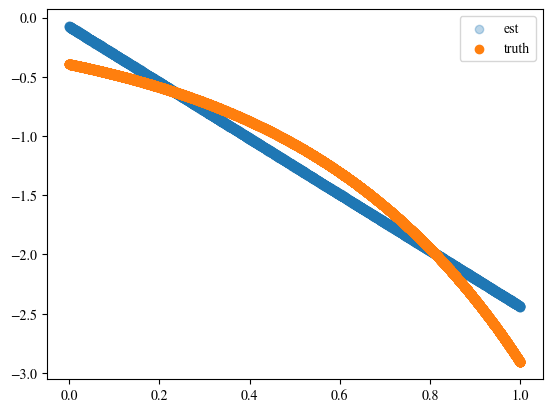

(-0.06994725169682026,
 array([-2.36385513, -0.00448348,  0.00277606, -0.00514042, -0.0057329 ]))

In [23]:
# Ideal BLP of Riesz Representer
test = LinearRegression().fit(X, atrue_fn(X))
plt.scatter(X[:, 0], test.predict(X), label='est', alpha=.3)
plt.scatter(X[:, 0], atrue_fn(X), label='truth')
plt.legend()
plt.show()
test.intercept_, test.coef_

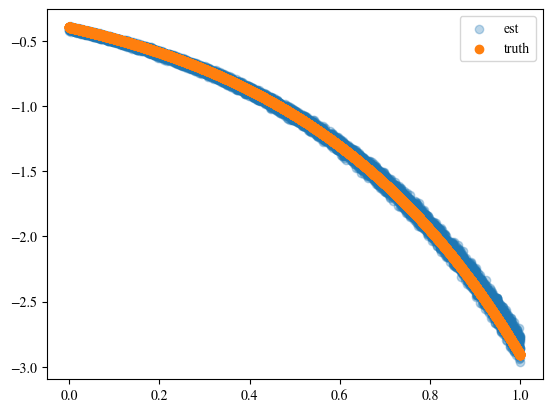

-1.3582960241884503

In [24]:
# Plugin Approach
att = make_pipeline(Poly(degree=1), RieszWrapper(LogisticRegression(random_state=123)))
att.fit(X, D)
plt.scatter(X[:, 0], att.predict(X), label='est', alpha=.3)
plt.scatter(X[:, 0], atrue_fn(X), label='truth')
plt.legend()
plt.show()
riesz_loss(att.predict(Xtest), Dtest)

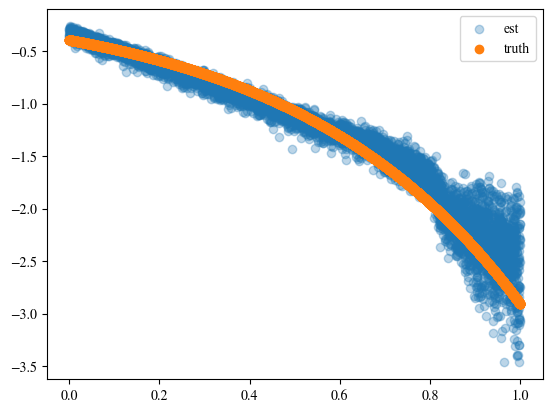

-1.3479165501562713

In [25]:
# AutoDML with Forests
att = RFrr(max_depth=3, min_samples_leaf=20, min_var_fraction_leaf=.1, min_var_leaf_on_val=True, l2=0.05)
att.fit(X, D)
plt.scatter(X[:, 0], att.predict(X), label='est', alpha=.3)
plt.scatter(X[:, 0], atrue_fn(X), label='truth')
plt.legend()
plt.show()
riesz_loss(att.predict(Xtest), Dtest)

In [26]:
# AutoDML with Neural Nets
p = .1
n_hidden = 100
learner = nn.Sequential(nn.Dropout(p=p), nn.Linear(X.shape[1], n_hidden), nn.ReLU(),
                        nn.Dropout(p=p), nn.Linear(n_hidden, n_hidden), nn.ReLU(),
                        nn.Dropout(p=p), nn.Linear(n_hidden, 1))
# learner = nn.Sequential(nn.Dropout(p=p), nn.Linear(X.shape[1], 1))
att = RieszNetRR(learner=learner, verbose=0, bs=200, n_epochs=100, learner_lr=1e-4)
att.fit(X, D)

RieszNetRR(bs=200,
           learner=Sequential(
  (0): Dropout(p=0.1, inplace=False)
  (1): Linear(in_features=5, out_features=100, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.1, inplace=False)
  (4): Linear(in_features=100, out_features=100, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.1, inplace=False)
  (7): Linear(in_features=100, out_features=1, bias=True)
))

In [27]:
riesz_loss(att.predict(Xtest), Dtest)

-1.3310683965682983

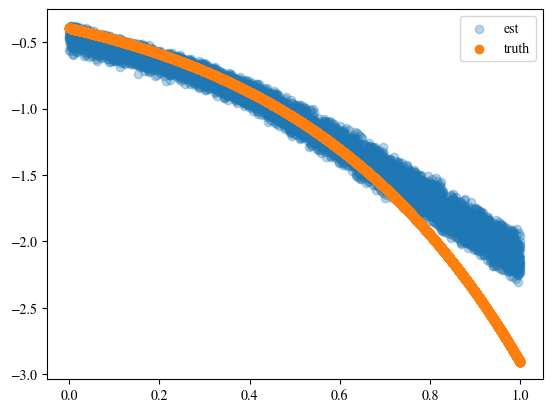

In [28]:
plt.scatter(X[:, 0], att.predict(X), label='est', alpha=.3)
plt.scatter(X[:, 0], atrue_fn(X), label='truth')
plt.legend()
plt.show()

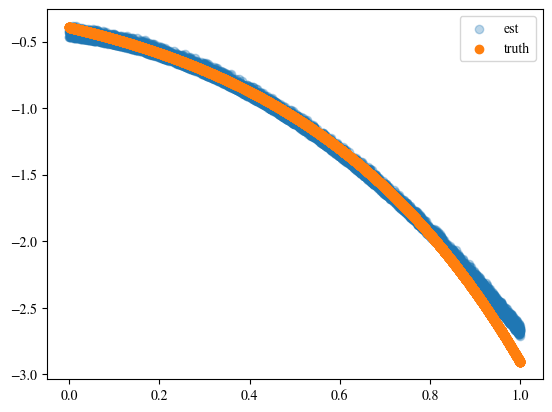

-1.3573499255516144

In [29]:
# AutoDML with fixed Regularization
att = make_pipeline(Poly(degree=2), StandardScaler(),
                    ATTAutoDML(trimming=0.01, alpha=0.01, tol=1e-12, max_iter=10000))
att.fit(X, D)
plt.scatter(X[:, 0], att.predict(X), label='est', alpha=.3)
plt.scatter(X[:, 0], atrue_fn(X), label='truth')
plt.legend()
plt.show()
riesz_loss(att.predict(Xtest), Dtest)

-1.3360576120346515 0.026560877829466867 9.523801969280044e-09 196


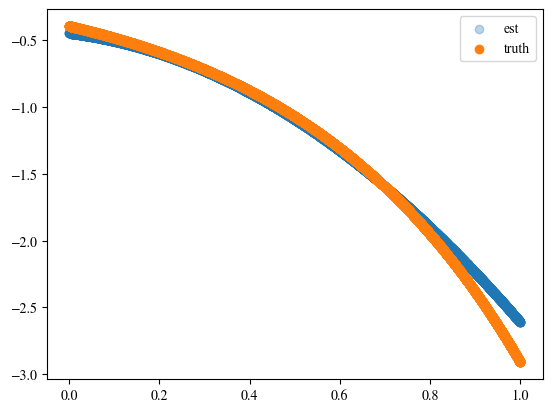

-1.3560207736943002

In [30]:
# AutoDML with cross-validated Regularization
att = make_pipeline(Poly(degree=2), StandardScaler(),
                    ATTAutoDMLCV(trimming=0.01, n_alphas=100, tol=1e-8, max_iter=1000))
att.fit(X, D)
print(att[-1].loss_, att[-1].alpha_, att[-1].tol_, att[-1].n_iter_)
plt.scatter(X[:, 0], att.predict(X), label='est', alpha=.3)
plt.scatter(X[:, 0], atrue_fn(X), label='truth')
plt.legend()
plt.show()
riesz_loss(att.predict(Xtest), Dtest)

-1.3360324506050971 Pipeline(steps=[('poly', Poly()), ('standardscaler', StandardScaler()),
                ('attautodmlcv', ATTAutoDMLCV())]) 0.026560877829466867 9.688633153037696e-05 63


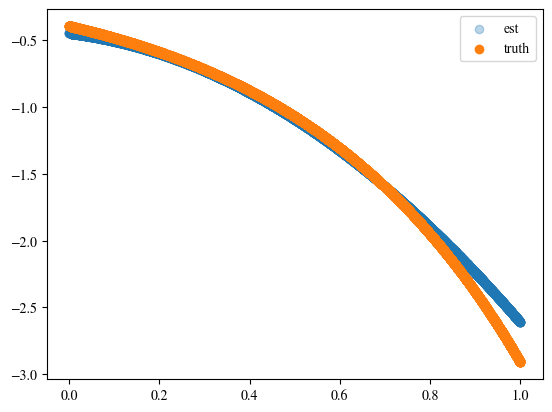

-1.3560370328649933

In [31]:
# AutoDML with cross-validated regularization and degree of linear sieve
best = np.inf
for degree in [1, 2, 3]:
    att = make_pipeline(Poly(degree=degree), StandardScaler(),
                        ATTAutoDMLCV(trimming=0.01, n_alphas=100, tol=1e-4, max_iter=1000))
    att.fit(X, D)
    if att[-1].loss_ < best:
        best = att[-1].loss_
        best_att = att
att = best_att
print(att[-1].loss_, att, att[-1].alpha_, att[-1].tol_, att[-1].n_iter_)
plt.scatter(X[:, 0], att.predict(X), label='est', alpha=.3)
plt.scatter(X[:, 0], atrue_fn(X), label='truth')
plt.legend()
plt.show()
riesz_loss(att.predict(Xtest), Dtest)

## Semi-Synthetic Data

In [33]:
def get_nuisance_learners(X):
    ''' Constructs the learners we will consider for nuisance estimation

    X: the dataframe of covariates; to be used for setting some parameters of
        the learners

    Returns: a dictionary of learners of the form {key: (ml_g, ml_m)}
    '''
    region_names = [col for col in X.columns if col.startswith('region_')]
    # a formula that will be used within a featurizer to create interactions
    # (region id) * (baseline outcome) + (region id) + (baseline outcomes)
    formula = '0 + ' + ' + '.join([f"{col} * (lemp_0 + lpop_0 + lavg_pay_0)" for col in region_names])
    # a generic polynomial featurizer
    poly = lambda: PolynomialFeatures(degree=3, interaction_only=True, include_bias=False)
    p = .0
    n_hidden = 200
    learner = nn.Sequential(nn.Dropout(p=p), nn.Linear(X.shape[1], n_hidden), nn.ReLU(),
                            nn.Dropout(p=p), nn.Linear(n_hidden, n_hidden), nn.ReLU(),
                            nn.Dropout(p=p), nn.Linear(n_hidden, 1))
    learners = {
        # no X
        "No Controls": (DummyRegressor(strategy="mean"), DummyClassifier(strategy="prior")),
        # linear models of X
        "Basic": (LinearRegression(), LogisticRegression(random_state=123)),
        # linear models with region interactions
        "Expansion": (make_pipeline(FormulaTransformer(formula), LinearRegression()),
                      make_pipeline(FormulaTransformer(formula), StandardScaler(),
                                    LogisticRegression(random_state=123))),
        "AutoDML": (make_pipeline(FormulaTransformer(formula), LinearRegression()),
                    make_pipeline(FormulaTransformer(formula), StandardScaler(),
                                  ATTAutoDML(trimming=0.05, alpha=.01, tol=1e-4, max_iter=1000))),
        # Random Forest regressors and autodml
        "AutoDML (RF)": (RandomForestRegressor(n_estimators=100, min_samples_leaf=20, max_features=4, n_jobs=-1, random_state=123),
                         RFrr(n_estimators=100, min_samples_leaf=20, max_depth=3, l2=0.05,
                              min_var_fraction_leaf=.1, min_var_leaf_on_val=True,
                              max_samples=.6, random_state=123)),
        # "AutoDML (NN)": (RandomForestRegressor(n_estimators=100, min_samples_leaf=20, max_features=4, n_jobs=-1, random_state=123),
        #                  RieszNetRR(learner=learner, bs=200, n_epochs=500)),
    }
    return learners

Estimating ATET for year 2004. Please wait.
Index(['lemp_0', 'lpop_0', 'lavg_pay_0', 'region_2', 'region_3', 'region_4'], dtype='object')
Estimating No Controls.
Estimating Basic.
Estimating Expansion.
Estimating AutoDML.
Estimating AutoDML (RF).


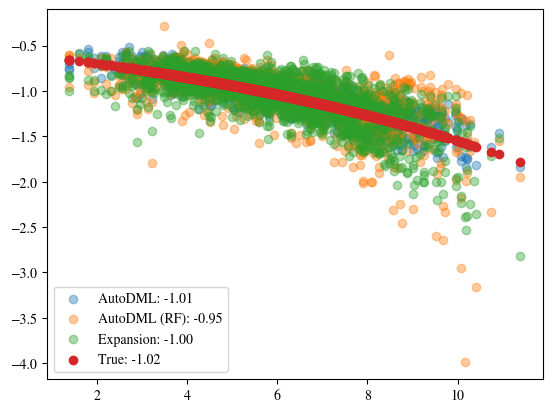

In [44]:
import matplotlib.pyplot as plt

def MinWageDiD(years):
    # arrays for saving the results
    att, se_att, RieszL, RMSE_y = {}, {}, {}, {}

    for year in years:
        print(f"Estimating ATET for year {year}. Please wait.")
        att[year], se_att[year], RieszL[year], RMSE_y[year] = {}, {}, {}, {}

        # set up the data for the specific year
        np.random.seed(123)
        X = did_data[year].drop(columns=["treated", "dy"]) # controls
        prop = lambda x: scipy.special.expit(.1 * x[:, 0].astype(np.float64))
        D = np.random.binomial(1, prop(X.values))
        ptrue = np.mean(D)
        atrue_fn = lambda x: - ((1 - ptrue) / ptrue) * prop(x) / (1 - prop(x))
        dy = -.04 * D + .1 * X.values[:, 0] + np.random.normal(0, np.std(did_data[year].dy.values), size=X.shape[0])

        print(X.columns)

        # get dictionary of nuisance learners
        learners = get_nuisance_learners(X)

        # for storing the nuisance predictions
        pred_y, pred_a = {}, {}
        best_rmsey = np.inf
        best_rloss = np.inf
        for method, (ml_g, ml_m) in learners.items():
            print(f"Estimating {method}.")
            if method.startswith("AutoDML"):
                ml_a = ml_m
            else:
                ml_a = RieszWrapper(ml_m, trimming=0.05)
            point, stderr, dyhat, ahat, rmsey, rieszloss, phat = dr_att(X, D, dy, ml_g, ml_a, nfolds=5)
            pred_y[method], pred_a[method] = dyhat, ahat
            att[year][method], se_att[year][method] = point, stderr
            RMSE_y[year][method], RieszL[year][method] = rmsey, rieszloss
            if rmsey < best_rmsey:
                ml_g_best = ml_g
                best_rmsey = rmsey
                best_g = method
            if rieszloss < best_rloss:
                ml_a_best = ml_a
                best_rloss = rieszloss
                best_a = method

        method = f"Best ({best_g}, {best_a})"
        point, stderr, dyhat, ahat, rmsey, rieszloss, phat = dr_att(X, D, dy, ml_g_best, ml_a_best, nfolds=5)
        pred_y[method], pred_a[method] = dyhat, ahat
        att[year][method], se_att[year][method] = point, stderr
        RMSE_y[year][method], RieszL[year][method] = rmsey, rieszloss

        plt.scatter(X.values[:, 0], pred_a['AutoDML'], label=f"AutoDML: {RieszL[year]['AutoDML']:.2f}", alpha=.4)
        plt.scatter(X.values[:, 0], pred_a['AutoDML (RF)'], label=f"AutoDML (RF): {RieszL[year]['AutoDML (RF)']:.2f}", alpha=.4)
        # plt.scatter(X.values[:, 0], pred_a['AutoDML (NN)'], label=f"AutoDML (NN): {RieszL[year]['AutoDML (NN)']:.2f}", alpha=.4)
        plt.scatter(X.values[:, 0], pred_a['Expansion'], label=f"Expansion: {RieszL[year]['Expansion']:.2f}", alpha=.4)
        plt.scatter(X.values[:, 0], atrue_fn(X.values), label=f"True: {riesz_loss(atrue_fn(X.values), D):.2f}")
        plt.legend()
        plt.show()

    return att, se_att, RMSE_y, RieszL

att, se_att, RMSE_y, RieszL = MinWageDiD([2004])

In [45]:
table2 = pd.concat({'att': pd.DataFrame(att),
                    'se': pd.DataFrame(se_att),
                    'RMSE dy': pd.DataFrame(RMSE_y),
                    'RieszL': pd.DataFrame(RieszL)}, axis=1)
table2 = table2.swaplevel(0, 1, axis=1)
table2 = table2.sort_index(axis=1)
table2

2004                              
                        RMSE dy    RieszL       att        se
AutoDML                0.162126 -1.012967 -0.037846  0.006997
AutoDML (RF)           0.162520 -0.952236 -0.037515  0.006974
Basic                  0.161237 -1.006264 -0.038123  0.006981
Best (Basic, AutoDML)  0.161237 -1.012967 -0.038179  0.006956
Expansion              0.162126 -0.995330 -0.037885  0.007040
No Controls            0.223690 -1.000000 -0.014386  0.009429

## Applying to Real Data

In [50]:
from sklearn.preprocessing import StandardScaler

def get_nuisance_learners(X):
    ''' Constructs the learners we will consider for nuisance estimation

    X: the dataframe of covariates; to be used for setting some parameters of
        the learners

    Returns: a dictionary of learners of the form {key: (ml_g, ml_m)}
    '''
    region_names = [col for col in X.columns if col.startswith('region_')]
    # a formula that will be used within a featurizer to create interactions
    # (region id) * (baseline outcome) + (region id) + (baseline outcomes)
    formula = '0 + ' + ' + '.join([f"{col} * (lemp_0 + lpop_0 + lavg_pay_0)" for col in region_names])
    # a generic polynomial featurizer
    poly = lambda: PolynomialFeatures(degree=3, interaction_only=False, include_bias=False)
    p = .0
    n_hidden = 200
    learner = nn.Sequential(nn.Dropout(p=p), nn.Linear(X.shape[1], n_hidden), nn.LeakyReLU(),
                            nn.Dropout(p=p), nn.Linear(n_hidden, n_hidden), nn.LeakyReLU(),
                            nn.Dropout(p=p), nn.Linear(n_hidden, 1))
    learners = {
        # no X
        "No Controls": (DummyRegressor(strategy="mean"), DummyClassifier(strategy="prior")),
        # linear models of X
        "Basic": (LinearRegression(), LogisticRegression(random_state=123)),
        # linear models with region interactions
        "Expansion": (make_pipeline(FormulaTransformer(formula), LinearRegression()),
                      make_pipeline(FormulaTransformer(formula), StandardScaler(), LogisticRegression(random_state=123))),
        # full blown third degree interactions of X, with Lasso
        "Lasso (CV)": (make_pipeline(poly(), StandardScaler(), LassoCV(n_jobs=-1, random_state=123)),
                       make_pipeline(poly(), StandardScaler(), LogisticRegressionCV(n_jobs=-1, random_state=123))),
        # full blown third degree interactions, with Ridge
        "Ridge (CV)": (make_pipeline(poly(), StandardScaler(), RidgeCV()),
                       make_pipeline(poly(), StandardScaler(), LogisticRegressionCV(n_jobs=-1, random_state=123))),
        # Random Forest regressors and classifiers
        "Random Forest": (RandomForestRegressor(n_estimators=100, min_samples_leaf=20, max_features=4, n_jobs=-1, random_state=123),
                          RandomForestClassifier(n_estimators=100, min_samples_leaf=20, max_features=4, n_jobs=-1, random_state=123)),
        # Sparse linear Autodml with small feature expansion
        "AutoDML (sp-linear, low)": (make_pipeline(FormulaTransformer(formula), LinearRegression()),
                    make_pipeline(FormulaTransformer(formula), StandardScaler(),
                                  ATTAutoDMLCV(trimming=0.05, n_alphas=200, tol=1e-4, max_iter=1000))),
        # Random Forest regressors and autodml
        "AutoDML (RF)": (RandomForestRegressor(n_estimators=100, min_samples_leaf=20, max_features=4, n_jobs=-1, random_state=123),
                         RFrr(n_estimators=100, min_samples_leaf=20, max_depth=5, l2=0.05,
                              min_var_fraction_leaf=.1, min_var_leaf_on_val=True,
                              max_samples=.6, random_state=123)),
        # Sparse linear auto-dml with high dimensional feature expansion
        "AutoDML (sp-linear, high)": (make_pipeline(poly(), StandardScaler(), LassoCV(n_jobs=-1, random_state=123)),
                           make_pipeline(poly(), StandardScaler(),
                                         ATTAutoDMLCV(trimming=0.05, n_alphas=200, tol=1e-4, max_iter=1000))),
        # Forest Regression and Neural Net AutoDML
        "AutoDML (NN)": (RandomForestRegressor(n_estimators=100, min_samples_leaf=20, max_features=4, n_jobs=-1, random_state=123),
                         RieszNetRR(learner=learner, bs=100, n_epochs=500, verbose=0)),
    }
    return learners

Estimating ATET for year 2004. Please wait.
Index(['lemp_0', 'lpop_0', 'lavg_pay_0', 'region_2', 'region_3', 'region_4'], dtype='object')
Estimating No Controls.
-1.0
Estimating Basic.
-3.0769790906903673
Estimating Expansion.
-3.025623000329687
Estimating Random Forest.
-3.034884115485223
Estimating AutoDML.
-3.5273879888890427
Estimating AutoDML (RF).
-2.9291814779442245
Estimating AutoDML (NN).
-2.8101398944854736


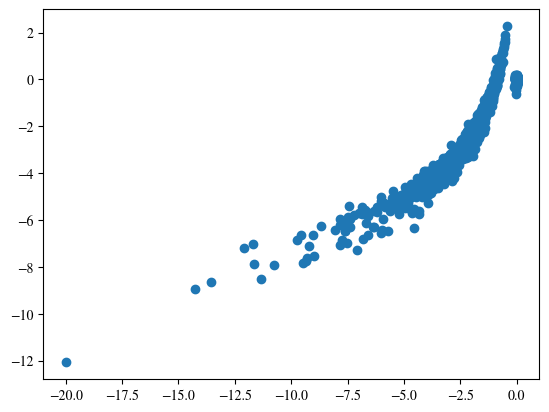

Estimating ATET for year 2005. Please wait.
Index(['lemp_0', 'lpop_0', 'lavg_pay_0', 'region_2', 'region_3', 'region_4'], dtype='object')
Estimating No Controls.
-1.0
Estimating Basic.
-2.882687032961033
Estimating Expansion.
-2.796806571858822
Estimating Random Forest.
-2.854077671037383
Estimating AutoDML.
-3.439330538886234
Estimating AutoDML (RF).
-2.8538499892950107
Estimating AutoDML (NN).
-2.768397092819214


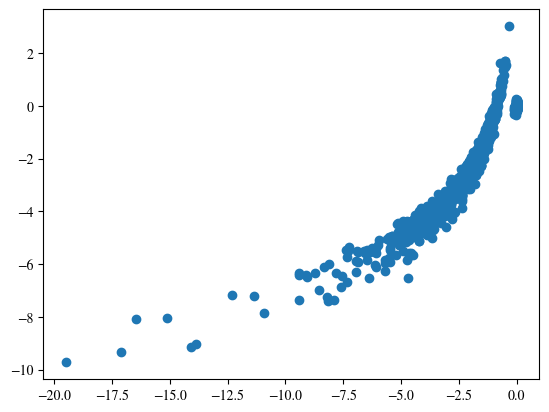

Estimating ATET for year 2006. Please wait.
Index(['lemp_0', 'lpop_0', 'lavg_pay_0', 'region_2', 'region_3', 'region_4'], dtype='object')
Estimating No Controls.
-1.0
Estimating Basic.
-3.0698788527872014
Estimating Expansion.
-2.899447662841391
Estimating Random Forest.
-3.252728347570428
Estimating AutoDML.
-3.48339274442211
Estimating AutoDML (RF).
-3.2198963882410707
Estimating AutoDML (NN).
-2.8890929222106934


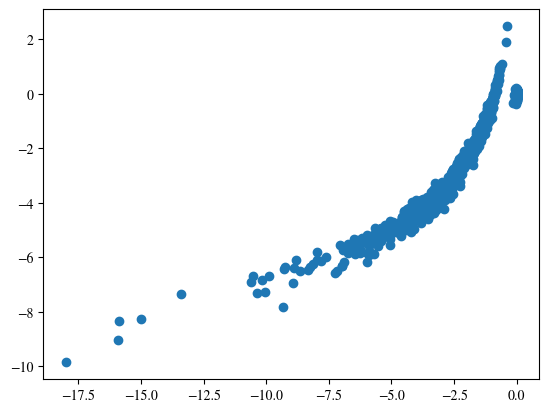

Estimating ATET for year 2007. Please wait.
Index(['lemp_0', 'lpop_0', 'lavg_pay_0', 'region_3', 'region_4'], dtype='object')
Estimating No Controls.
-1.0
Estimating Basic.
-5.5378994977494225
Estimating Expansion.
-5.272644370194478
Estimating Random Forest.
-4.968316910428839
Estimating AutoDML.
-6.013683689193435
Estimating AutoDML (RF).
-4.648044335267798
Estimating AutoDML (NN).
-4.7511537075042725


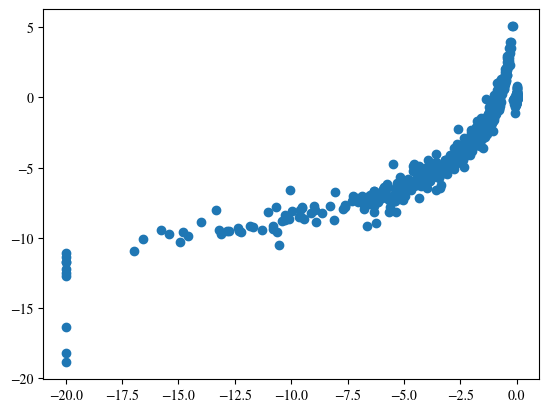

In [51]:
import matplotlib.pyplot as plt

def MinWageDiD(years):
    # arrays for saving the results
    att, se_att, RieszL, RMSE_y = {}, {}, {}, {}

    for year in years:
        print(f"Estimating ATET for year {year}. Please wait.")
        att[year], se_att[year], RieszL[year], RMSE_y[year] = {}, {}, {}, {}

        # set up the data for the specific year
        X = did_data[year].drop(columns=["treated", "dy"]) # controls
        D = did_data[year].treated.values # treatment
        dy = did_data[year].dy.values # delta outcome betwee post and pre treatment
        print(X.columns)

        # get dictionary of nuisance learners
        learners = get_nuisance_learners(X)

        # for storing the nuisance predictions
        pred_y, pred_a = {}, {}
        best_rmsey = np.inf
        best_rloss = np.inf
        for method, (ml_g, ml_m) in learners.items():
            print(f"Estimating {method}.")
            if method.startswith("AutoDML"):
                ml_a = ml_m
            else:
                ml_a = RieszWrapper(ml_m, trimming=0.05)
            point, stderr, dyhat, ahat, rmsey, rieszloss, phat = dr_att(X, D, dy, ml_g, ml_a, nfolds=5)
            pred_y[method], pred_a[method] = dyhat, ahat
            att[year][method], se_att[year][method] = point, stderr
            RMSE_y[year][method], RieszL[year][method] = rmsey, rieszloss
            print(rieszloss)
            if rmsey < best_rmsey:
                ml_g_best = ml_g
                best_rmsey = rmsey
                best_g = method
            if rieszloss < best_rloss:
                ml_a_best = ml_a
                best_rloss = rieszloss
                best_a = method

        method = f"Best ({best_g}, {best_a})"
        point, stderr, dyhat, ahat, rmsey, rieszloss, phat = dr_att(X, D, dy, ml_g_best, ml_a_best, nfolds=5)
        pred_y[method], pred_a[method] = dyhat, ahat
        att[year][method], se_att[year][method] = point, stderr
        RMSE_y[year][method], RieszL[year][method] = rmsey, rieszloss

        plt.scatter(pred_a['Expansion'], pred_a['AutoDML'])
        plt.show()

    return att, se_att, RMSE_y, RieszL

att, se_att, RMSE_y, RieszL = MinWageDiD([2004, 2005, 2006, 2007])

We start by reporting the RMSE obtained during cross-fitting for each learner in each period.

In [52]:
table1 = pd.concat({'RMSE dy': pd.DataFrame(RMSE_y),
                    'RieszL': pd.DataFrame(RieszL)}, axis=1)
table1 = table1.swaplevel(0, 1, axis=1)
table1 = table1.sort_index(axis=1)
table1

2004                2005                2006  \
                        RMSE dy    RieszL   RMSE dy    RieszL   RMSE dy   
No Controls            0.163240 -1.000000  0.188136 -1.000000  0.223408   
Basic                  0.163042 -3.076979  0.185159 -2.882687  0.217356   
Expansion              0.163512 -3.025623  0.185682 -2.796807  0.218003   
Random Forest          0.165177 -3.034884  0.187938 -2.854078  0.220051   
AutoDML                0.163512 -3.527388  0.185682 -3.439331  0.218003   
AutoDML (RF)           0.165177 -2.929181  0.187938 -2.853850  0.220051   
AutoDML (NN)           0.165177 -2.810140  0.187938 -2.768397  0.220051   
Best (Basic, AutoDML)  0.163042 -3.527388  0.185159 -3.439331  0.217356   

                                     2007            
                         RieszL   RMSE dy    RieszL  
No Controls           -1.000000  0.230234 -1.000000  
Basic                 -3.069879  0.221772 -5.537899  
Expansion             -2.899448  0.221867 -5.272644  
Random Forest         -3.252728  0.222787 -4.968317  
AutoDML               -3.483393  0.221867 -6.013684  
AutoDML (RF)          -3.219896  0.222787 -4.648044  
AutoDML (NN)          -2.889093  0.222787 -4.751154  
Best (Basic, AutoDML) -3.483393  0.221772 -6.013684

It appears there is some signal in the regressors, as all methods outside of  LassoCV produce somewhat smaller RMSEs than the No Controls baseline. While it would be hard to reliably conclude which of the relatively good performing methods is statistically best here, Best (or a different ensemble) provides a good baseline that is principled in the sense that one could pre-commit to using the best learners without having first looked at the subsequent estimation results.

We report estimates of the ATET in each period in the following table, together with the aforementioned RMSE's.

In [53]:
table2 = pd.concat({'att': pd.DataFrame(att),
                    'se': pd.DataFrame(se_att),
                    'RMSE dy': pd.DataFrame(RMSE_y),
                    'RieszL': pd.DataFrame(RieszL)}, axis=1)
table2 = table2.swaplevel(0, 1, axis=1)
table2 = table2.sort_index(axis=1)
table2

2004                                    2005  \
                        RMSE dy    RieszL       att        se   RMSE dy   
No Controls            0.163240 -1.000000 -0.040091  0.019007  0.188136   
Basic                  0.163042 -3.076979 -0.023583  0.020041  0.185159   
Expansion              0.163512 -3.025623 -0.021850  0.020428  0.185682   
Random Forest          0.165177 -3.034884 -0.022924  0.019185  0.187938   
AutoDML                0.163512 -3.527388 -0.023817  0.020260  0.185682   
AutoDML (RF)           0.165177 -2.929181 -0.022230  0.018775  0.187938   
AutoDML (NN)           0.165177 -2.810140 -0.022805  0.018813  0.187938   
Best (Basic, AutoDML)  0.163042 -3.527388 -0.024450  0.019974  0.185159   

                                                         2006            \
                         RieszL       att        se   RMSE dy    RieszL   
No Controls           -1.000000 -0.076219  0.020100  0.223408 -1.000000   
Basic                 -2.882687 -0.047402  0.020848  0.217356 -3.069879   
Expansion             -2.796807 -0.047554  0.021089  0.218003 -2.899448   
Random Forest         -2.854078 -0.049055  0.020226  0.220051 -3.252728   
AutoDML               -3.439331 -0.042459  0.020974  0.218003 -3.483393   
AutoDML (RF)          -2.853850 -0.047440  0.019749  0.220051 -3.219896   
AutoDML (NN)          -2.768397 -0.044499  0.019943  0.220051 -2.889093   
Best (Basic, AutoDML) -3.439331 -0.042406  0.020826  0.217356 -3.483393   

                                               2007                      \
                            att        se   RMSE dy    RieszL       att   
No Controls           -0.116716  0.019744  0.230234 -1.000000 -0.131056   
Basic                 -0.052877  0.019795  0.221772 -5.537899 -0.067022   
Expansion             -0.053007  0.020455  0.221867 -5.272644 -0.065627   
Random Forest         -0.050588  0.019995  0.222787 -4.968317 -0.067330   
AutoDML               -0.051178  0.020411  0.221867 -6.013684 -0.064626   
AutoDML (RF)          -0.055399  0.019492  0.222787 -4.648044 -0.063812   
AutoDML (NN)          -0.053166  0.019592  0.222787 -4.751154 -0.064943   
Best (Basic, AutoDML) -0.051265  0.020034  0.221772 -6.013684 -0.064388   

                                 
                             se  
No Controls            0.022586  
Basic                  0.023419  
Expansion              0.024452  
Random Forest          0.023020  
AutoDML                0.025004  
AutoDML (RF)           0.022695  
AutoDML (NN)           0.023221  
Best (Basic, AutoDML)  0.024706

Here, we see that most methods provide point estimates that suggest the effect of the minimum wage increase leads to decreases in youth employment with small effects in the initial period that become larger in the years following the treatment. This pattern seems economically plausible as it may take time for firms to adjust employment and other input choices in response to a minimum wage change. In the estimates that are reported in the book we have values that are not consistent with this pattern, however, they systematically underperform in terms of having poor cross-fit prediction performance. In terms of point estimates, the other pattern that emerges is that all estimates that use the covariates produce ATET estimates that are systematically smaller in magnitude than the No Controls baseline, suggesting that failing to include the controls may lead to overstatement of treatment effects in this example.

Turning to inference, we would reject the hypothesis of no minimum wage effect two or more years after the change at the 5% level, even after multiple testing correction, if we were to focus on many of the estimators.

### Assess pre-trends

Because we have data for the period 2001-2007, we can perform a so-called pre-trends test to provide some evidence about the plausibility of the conditional parallel trends assumption. Specifically, we can continue to use 2003 as the reference period but now consider 2002 to be the treatment period. Sensible economic mechanisms underlying the assumption would then typically suggest that the ATET in 2002 - before the 2004 minimum wage change we are considering - should be zero. Finding evidence that the ATET in 2002 is non-zero then calls into question the validity of the assumption.

We change the treatment status of those observations, which received treatment in 2004 in the 2002 data and create a placebo treatment as well as control group. We call the same estimation pipeline that we used to obtain our ATET estimates for 2004-2007. We now hope that we get a statistical null result.

Estimating ATET for year 2002. Please wait.
Index(['lemp_0', 'lpop_0', 'lavg_pay_0', 'region_2', 'region_3', 'region_4'], dtype='object')
Estimating No Controls.
-1.0
Estimating Basic.
-2.638562851323874
Estimating Expansion.
-2.5550094960332466
Estimating Random Forest.
-1.54584467515026
Estimating AutoDML.
-3.0321986344604026
Estimating AutoDML (RF).
-2.6059155574731214
Estimating AutoDML (NN).
-2.5609700679779053


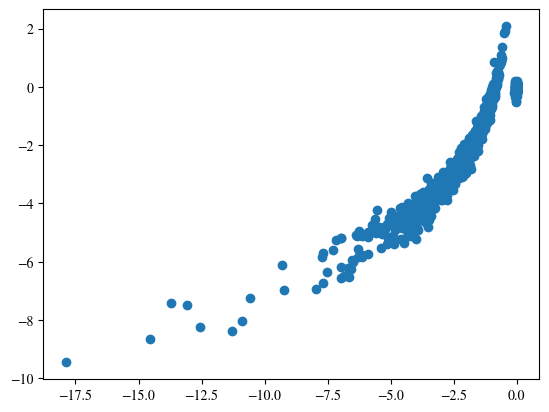

In [54]:
att, se_att, RMSE_y, RieszL = MinWageDiD([2002])

In [55]:
table2002 = pd.concat({'att': pd.DataFrame(att),
                    'se': pd.DataFrame(se_att),
                    'RMSE dy': pd.DataFrame(RMSE_y),
                    'RieszL': pd.DataFrame(RieszL)}, axis=1)
table2002 = table2002.swaplevel(0, 1, axis=1)
table2002 = table2002.sort_index(axis=1)
table2002

2002                              
                        RMSE dy    RieszL       att        se
AutoDML                0.154192 -3.032199  0.004521  0.014024
AutoDML (NN)           0.154875 -2.560970  0.001210  0.012478
AutoDML (RF)           0.154875 -2.605916  0.000452  0.012342
Basic                  0.154111 -2.638563  0.002798  0.014173
Best (Basic, AutoDML)  0.154111 -3.032199  0.005624  0.014164
Expansion              0.154192 -2.555009  0.002188  0.014317
No Controls            0.154471 -1.000000 -0.004773  0.013275
Random Forest          0.154875 -1.545845  0.001973  0.013007

Here we see broad agreement across all methods in the sense of returning point estimates that are small in magnitude and small relative to standard errors. In no case would we reject the hypothesis that the pre-event effect in 2002 is different from zero at usual levels of significance. We note that failing to reject the hypothesis of no pre-event effects certainly does not imply that the conditional DiD assumption is in fact satisfied. For example, confidence intervals include values that would be consistent with relatively large pre-event effects. However, it is reassuring to see that there is not strong evidence of a violation of the underlying identifying assumption.

### Visualizing the Effect of Treatment in 2004 Over the Years

In [56]:
table_all = pd.concat([table2002, table2], axis=1)
table_all

2002                                    2004  \
                        RMSE dy    RieszL       att        se   RMSE dy   
AutoDML                0.154192 -3.032199  0.004521  0.014024  0.163512   
AutoDML (NN)           0.154875 -2.560970  0.001210  0.012478  0.165177   
AutoDML (RF)           0.154875 -2.605916  0.000452  0.012342  0.165177   
Basic                  0.154111 -2.638563  0.002798  0.014173  0.163042   
Best (Basic, AutoDML)  0.154111 -3.032199  0.005624  0.014164  0.163042   
Expansion              0.154192 -2.555009  0.002188  0.014317  0.163512   
No Controls            0.154471 -1.000000 -0.004773  0.013275  0.163240   
Random Forest          0.154875 -1.545845  0.001973  0.013007  0.165177   

                                                         2005            \
                         RieszL       att        se   RMSE dy    RieszL   
AutoDML               -3.527388 -0.023817  0.020260  0.185682 -3.439331   
AutoDML (NN)          -2.810140 -0.022805  0.018813  0.187938 -2.768397   
AutoDML (RF)          -2.929181 -0.022230  0.018775  0.187938 -2.853850   
Basic                 -3.076979 -0.023583  0.020041  0.185159 -2.882687   
Best (Basic, AutoDML) -3.527388 -0.024450  0.019974  0.185159 -3.439331   
Expansion             -3.025623 -0.021850  0.020428  0.185682 -2.796807   
No Controls           -1.000000 -0.040091  0.019007  0.188136 -1.000000   
Random Forest         -3.034884 -0.022924  0.019185  0.187938 -2.854078   

                                               2006                      \
                            att        se   RMSE dy    RieszL       att   
AutoDML               -0.042459  0.020974  0.218003 -3.483393 -0.051178   
AutoDML (NN)          -0.044499  0.019943  0.220051 -2.889093 -0.053166   
AutoDML (RF)          -0.047440  0.019749  0.220051 -3.219896 -0.055399   
Basic                 -0.047402  0.020848  0.217356 -3.069879 -0.052877   
Best (Basic, AutoDML) -0.042406  0.020826  0.217356 -3.483393 -0.051265   
Expansion             -0.047554  0.021089  0.218003 -2.899448 -0.053007   
No Controls           -0.076219  0.020100  0.223408 -1.000000 -0.116716   
Random Forest         -0.049055  0.020226  0.220051 -3.252728 -0.050588   

                                     2007                                
                             se   RMSE dy    RieszL       att        se  
AutoDML                0.020411  0.221867 -6.013684 -0.064626  0.025004  
AutoDML (NN)           0.019592  0.222787 -4.751154 -0.064943  0.023221  
AutoDML (RF)           0.019492  0.222787 -4.648044 -0.063812  0.022695  
Basic                  0.019795  0.221772 -5.537899 -0.067022  0.023419  
Best (Basic, AutoDML)  0.020034  0.221772 -6.013684 -0.064388  0.024706  
Expansion              0.020455  0.221867 -5.272644 -0.065627  0.024452  
No Controls            0.019744  0.230234 -1.000000 -0.131056  0.022586  
Random Forest          0.019995  0.222787 -4.968317 -0.067330  0.023020

In [60]:
list(table_all.index)

['AutoDML',
 'AutoDML (NN)',
 'AutoDML (RF)',
 'Basic',
 'Best (Basic, AutoDML)',
 'Expansion',
 'No Controls',
 'Random Forest']

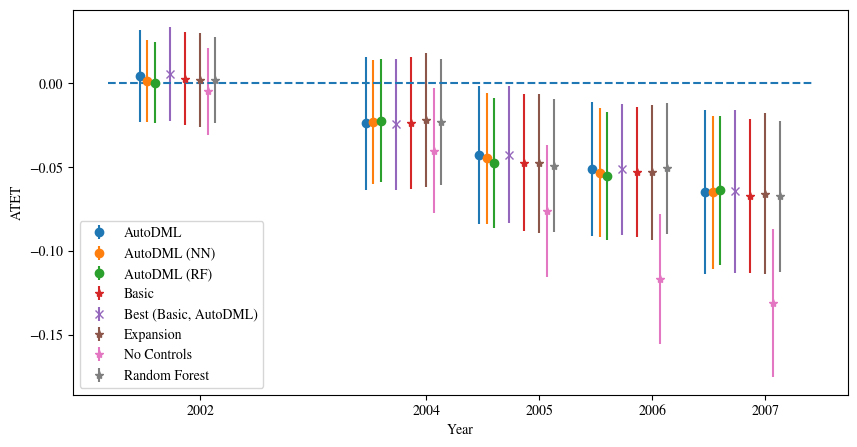

In [97]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
# plt.style.use("theme_bw.mplstyle")
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
plt.figure(figsize=(10, 5), facecolor="white")
years = np.array([2002, 2004, 2005, 2006, 2007])
nmethods = len(list(table_all.index))
for it, method in enumerate(list(table_all.index)):
    plt.errorbar(1.5*years + (it - nmethods) * .1 + (.0 if method.startswith("AutoDML") or method.startswith("Best") else .3),
                 np.array([table_all[year]['att'].loc[method] for year in years]),
                 yerr=1.96*np.array([table_all[year]['se'].loc[method] for year in years]),
                 fmt='o' if method.startswith("AutoDML") else ('x' if method.startswith("Best") else '*'), label=method)
plt.xticks(1.5 * years, years)
plt.legend()
plt.hlines(0, plt.xlim()[0], plt.xlim()[1], linestyles='dashed')
plt.xlabel(r'Year')
plt.ylabel(r'ATET')
plt.savefig("minwage_effects_gg.png", dpi=600)
plt.savefig("minwage_effects_gg.pdf", dpi=600)
plt.show()

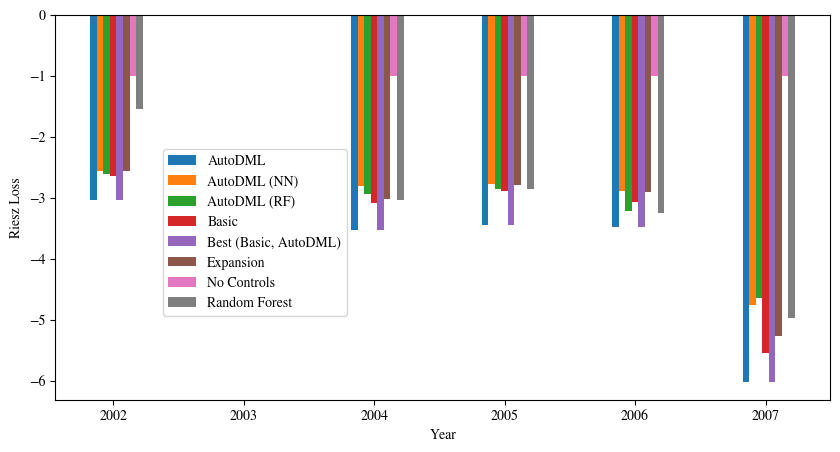

In [98]:
import matplotlib.pyplot as plt
import seaborn as sns
# plt.style.use("theme_bw.mplstyle")
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
plt.figure(figsize=(10, 5), facecolor="white")
years = np.array([2002, 2004, 2005, 2006, 2007])
for it, method in enumerate(list(table_all.index)):
    plt.bar(years + (it - 3) * .05,
            np.array([table_all[year]['RieszL'].loc[method] for year in years]),
            label=method, width=.05)
plt.legend(bbox_to_anchor=(0.13, 0., 0.8, 0.67))
plt.xlabel(r'Year')
plt.ylabel(r'Riesz Loss')
plt.savefig("minwage_effects_riesz_loss_gg.png", dpi=600)
plt.savefig("minwage_effects_riesz_loss_gg.pdf", dpi=600)
plt.show()

In [99]:
table_all = pd.concat([table2, table2002], axis=1)
table_all

2004                                    2005  \
                        RMSE dy    RieszL       att        se   RMSE dy   
No Controls            0.163240 -1.000000 -0.040091  0.019007  0.188136   
Basic                  0.163042 -3.076979 -0.023583  0.020041  0.185159   
Expansion              0.163512 -3.025623 -0.021850  0.020428  0.185682   
Random Forest          0.165177 -3.034884 -0.022924  0.019185  0.187938   
AutoDML                0.163512 -3.527388 -0.023817  0.020260  0.185682   
AutoDML (RF)           0.165177 -2.929181 -0.022230  0.018775  0.187938   
AutoDML (NN)           0.165177 -2.810140 -0.022805  0.018813  0.187938   
Best (Basic, AutoDML)  0.163042 -3.527388 -0.024450  0.019974  0.185159   

                                                         2006            \
                         RieszL       att        se   RMSE dy    RieszL   
No Controls           -1.000000 -0.076219  0.020100  0.223408 -1.000000   
Basic                 -2.882687 -0.047402  0.020848  0.217356 -3.069879   
Expansion             -2.796807 -0.047554  0.021089  0.218003 -2.899448   
Random Forest         -2.854078 -0.049055  0.020226  0.220051 -3.252728   
AutoDML               -3.439331 -0.042459  0.020974  0.218003 -3.483393   
AutoDML (RF)          -2.853850 -0.047440  0.019749  0.220051 -3.219896   
AutoDML (NN)          -2.768397 -0.044499  0.019943  0.220051 -2.889093   
Best (Basic, AutoDML) -3.439331 -0.042406  0.020826  0.217356 -3.483393   

                                               2007                      \
                            att        se   RMSE dy    RieszL       att   
No Controls           -0.116716  0.019744  0.230234 -1.000000 -0.131056   
Basic                 -0.052877  0.019795  0.221772 -5.537899 -0.067022   
Expansion             -0.053007  0.020455  0.221867 -5.272644 -0.065627   
Random Forest         -0.050588  0.019995  0.222787 -4.968317 -0.067330   
AutoDML               -0.051178  0.020411  0.221867 -6.013684 -0.064626   
AutoDML (RF)          -0.055399  0.019492  0.222787 -4.648044 -0.063812   
AutoDML (NN)          -0.053166  0.019592  0.222787 -4.751154 -0.064943   
Best (Basic, AutoDML) -0.051265  0.020034  0.221772 -6.013684 -0.064388   

                                     2002                                
                             se   RMSE dy    RieszL       att        se  
No Controls            0.022586  0.154471 -1.000000 -0.004773  0.013275  
Basic                  0.023419  0.154111 -2.638563  0.002798  0.014173  
Expansion              0.024452  0.154192 -2.555009  0.002188  0.014317  
Random Forest          0.023020  0.154875 -1.545845  0.001973  0.013007  
AutoDML                0.025004  0.154192 -3.032199  0.004521  0.014024  
AutoDML (RF)           0.022695  0.154875 -2.605916  0.000452  0.012342  
AutoDML (NN)           0.023221  0.154875 -2.560970  0.001210  0.012478  
Best (Basic, AutoDML)  0.024706  0.154111 -3.032199  0.005624  0.014164

In [100]:
import joblib
joblib.dump(table_all, "table_all.jbl")

['table_all.jbl']

In [101]:
print(table_all[[2004, 2005]].to_latex(escape=False, multicolumn=True, float_format="%.3f", column_format='r' + 'c'*8))
print(table_all[[2006, 2007]].to_latex(escape=False, multicolumn=True, float_format="%.3f", column_format='r' + 'c'*8))
print(table_all[[2002]].to_latex(escape=False, multicolumn=True, float_format="%.3f", column_format='r' + 'c'*4))

\begin{tabular}{rcccccccc}
\toprule
 & \multicolumn{4}{r}{2004} & \multicolumn{4}{r}{2005} \\
 & RMSE dy & RieszL & att & se & RMSE dy & RieszL & att & se \\
\midrule
No Controls & 0.163 & -1.000 & -0.040 & 0.019 & 0.188 & -1.000 & -0.076 & 0.020 \\
Basic & 0.163 & -3.077 & -0.024 & 0.020 & 0.185 & -2.883 & -0.047 & 0.021 \\
Expansion & 0.164 & -3.026 & -0.022 & 0.020 & 0.186 & -2.797 & -0.048 & 0.021 \\
Random Forest & 0.165 & -3.035 & -0.023 & 0.019 & 0.188 & -2.854 & -0.049 & 0.020 \\
AutoDML & 0.164 & -3.527 & -0.024 & 0.020 & 0.186 & -3.439 & -0.042 & 0.021 \\
AutoDML (RF) & 0.165 & -2.929 & -0.022 & 0.019 & 0.188 & -2.854 & -0.047 & 0.020 \\
AutoDML (NN) & 0.165 & -2.810 & -0.023 & 0.019 & 0.188 & -2.768 & -0.044 & 0.020 \\
Best (Basic, AutoDML) & 0.163 & -3.527 & -0.024 & 0.020 & 0.185 & -3.439 & -0.042 & 0.021 \\
\bottomrule
\end{tabular}

\begin{tabular}{rcccccccc}
\toprule
 & \multicolumn{4}{r}{2006} & \multicolumn{4}{r}{2007} \\
 & RMSE dy & RieszL & att & se & RMSE dy & Rie

# Variant of ATT Class that Does Not Cross-fit the Treated Samples

In [102]:
from sklearn.utils import _safe_indexing
from sklearn.base import clone

def final_stage(D, y, ahat, yhat, phat):
    # doubly robust quantity for every sample
    phihat = (D / phat) * (y - yhat)
    phihat += ((1 - D) / (1 - phat)) * ahat * (y - yhat) # ahat = ((1 - phat) / phat) * Pr(D|X) / (1 - Pr(D|X))
    point = np.mean(phihat) / np.mean(D / phat)
    # influence function
    phihat = (phihat - point * (D / phat)) / np.mean(D / phat)
    var = np.mean(np.square(phihat))
    stderr = np.sqrt(var / D.shape[0])
    return point, stderr

def riesz_loss(ahat, D):
    return - 2 * np.mean(- ahat[D==1]) + np.mean(ahat[D==0]**2)

def dr_att(X, D, y, modely, modela, *, nfolds=5):
    '''
    DML for the ATT estimation (Doubly Robust Learning)
    with cross-fitting

    Input
    -----
    X: the controls, pandas DataFrame
    D: treatment indicator, numpy array
    y: the outcome (the delta before and after intervention in DiD), numpy array
    modely: the ML model for predicting y (the delta Y_1 - Y_0 in DiD)
    modela: the ML model for predicting the treatment Riesz representer
    nfolds: the number of folds in cross-fitting, int (default=5)

    Output
    ------
    point: the point estimate of the treatment on the treated
    stderr: the standard error of the treatment effect
    yhat: cross-fitted predictions of the outcome y under control, E[y|D=0, X]
    ahat: cross-fitted predictions of the Riesz representer
    rmsey: the RMSE of the model y ~ X | D==0
    rieszloss: the out-of-sample Riesz loss of the Riesz model
    phat: the estimated treatment probability in each fold
    '''
    if nfolds == 1:
        splits = [(np.arange(X.shape[0]), np.arange(X.shape[0]))]
    else:
        cv = StratifiedKFold(n_splits=nfolds, shuffle=True, random_state=1234)
        splits = list(cv.split(X, D))
    # fit a model E[y | D=0, X]
    yhat = np.zeros(y.shape)
    ahat = np.zeros(y.shape)
    treated = np.argwhere(D==1).flatten()
    for train, test in splits:
        # treated units don't need to be crossfitted
        train = np.union1d(train, treated)
        test = np.union1d(test, treated)
        fitted_modely = clone(modely).fit(_safe_indexing(X, train)[D[train]==0], y[train][D[train]==0])
        # baseline response predictions
        yhat[test] += fitted_modely.predict(_safe_indexing(X, test))
        fitted_modela = clone(modela).fit(_safe_indexing(X, train), D[train])
        # Riesz scores
        ahat[test] += fitted_modela.predict(_safe_indexing(X, test))
    # since we prediced on the treated for each fold, we divided by the folds
    # to take the average
    ahat[treated] = ahat[treated] / nfolds
    yhat[treated] = yhat[treated] / nfolds

    # Use the fraction of treated as estimate of phat
    phat = np.mean(D)

    # estimation of parameter
    point, stderr = final_stage(D, y, ahat, yhat, phat)

    # out-of-sample outcome regression function rmse's
    rmsey = np.sqrt(np.mean((y - yhat)[D==0]**2))

    # out-of-sample riesz regression loss
    rieszl = riesz_loss(ahat, D)

    return point, stderr, yhat, ahat, rmsey, rieszl, phat

Estimating ATET for year 2007. Please wait.
Index(['lemp_0', 'lpop_0', 'lavg_pay_0', 'region_3', 'region_4'], dtype='object')
Estimating No Controls.
-1.0
Estimating Basic.
-5.821397413755037
Estimating Expansion.
-5.641132525497016
Estimating Random Forest.
-8.013225055366354
Estimating AutoDML.
-6.2098165061641355
Estimating AutoDML (RF).
-5.54261640390845
Estimating AutoDML (NN).
-5.3978426660008365


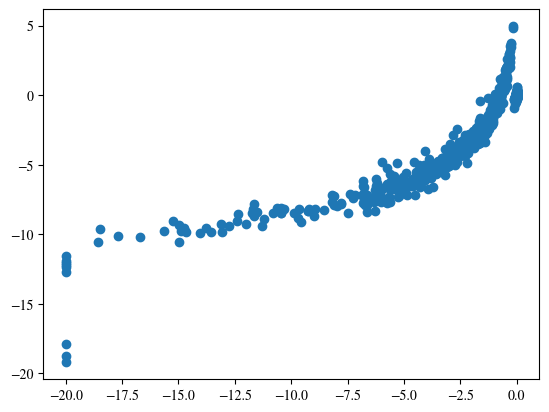

In [103]:
att, se_att, RMSE_y, RieszL = MinWageDiD([#2004, 2005, 2006,
                                          2007])

In [104]:
table2 = pd.concat({'att': pd.DataFrame(att),
                    'se': pd.DataFrame(se_att),
                    'RMSE dy': pd.DataFrame(RMSE_y),
                    'RieszL': pd.DataFrame(RieszL)}, axis=1)
table2 = table2.swaplevel(0, 1, axis=1)
table2 = table2.sort_index(axis=1)
table2

2007                              
                              RMSE dy    RieszL       att        se
AutoDML                      0.221867 -6.209817 -0.066747  0.025097
AutoDML (NN)                 0.222787 -5.397843 -0.064355  0.023513
AutoDML (RF)                 0.222787 -5.542616 -0.068397  0.022802
Basic                        0.221772 -5.821397 -0.066431  0.023635
Best (Basic, Random Forest)  0.221772 -8.013225 -0.067187  0.022898
Expansion                    0.221867 -5.641133 -0.065986  0.024749
No Controls                  0.230234 -1.000000 -0.131092  0.022570
Random Forest                0.222787 -8.013225 -0.069218  0.023088